In [10]:
import numpy as np
import EFIE as solve
light_speed, mu0, eps0 = 299792458., 4*np.pi*1e-7, 8.854e-12

frequency = 1e6 * 146
omega, wavelength = 2 * np.pi * frequency, light_speed / frequency
incident_field, radius = 10, 3.175e-3
delta_r = wavelength / 100

class yagi:
    def __init__(self, position, angle, length, source_position, radius):
        self.position = position
        self.angle = angle
        self.length = length
        self.source_position = source_position
        self.radius = radius

class tree:
    def __init__(self, its, phi, length, f, radius, field):
        self.its = its
        self.phi = phi
        self.length = length
        self.f = f
        self.radius = radius
        self.field = field

class symetric_tree:
    def __init__(self, its, phi, length, f, radius, field):
        self.its = its
        self.phi = phi
        self.length = length
        self.f = f
        self.radius = radius
        self.field = field

class circle:
    def __init__(self, R, radius, center, source_position):
        self.R = R
        self.radius = radius
        self.source_position = source_position
        self.center = center

class mixed:
    def __init__(self, yagis=None, trees=None, circles=None):
        self.yagis = yagis if yagis is not None else []
        self.trees = trees if trees is not None else []
        self.circles = circles if circles is not None else []

    def add_yagi(self, yagi_obj):
        self.yagis.append(yagi_obj)

    def add_tree(self, tree_obj):
        self.trees.append(tree_obj)

    def add_circle(self, circle_obj):
        self.circles.append(circle_obj)

#R = np.array([wavelength/40, wavelength/40])
#radius = np.full(2, 3.175e-3)
#center = np.array([[0.0, 0.0, 0.0], [wavelength/4, 0.0, 0.0]])
#source_position = np.array([[wavelength/10, 0.0, 0.0, incident_field]])
#test_circle = circle(R, radius, center, source_position)

position = np.array([[0.0, 0.0, 0.0], [0.0, wavelength/5, 0.0]])
angle = np.array([[np.pi/2, np.pi/2], [np.pi/2, np.pi/4]])
length = np.array([delta_r*2, delta_r*2])
source_position = np.array([[0.0, 0.0, 0.0, incident_field]])
radii = np.array([radius, radius])
test_yagi = yagi(position, angle, length, source_position, radii)
structure_type = 'yagi-uda'
basis_functions = 'triangle'

its = 3
phi = np.random.uniform(0, np.pi/2, 2 * (2 ** its-1) )
length = wavelength/10
f = 1
radius = 3.175e-3
field = incident_field
structure_type = 'tree'
basis_functions = 'triangle'
test_tree = tree(its, phi, length, f, radius, field)
       
        
#structure_type = 'mixed'
#basis_functions = 'triangle'
#test_yagi = yagi(np.array([[0.0,0.0,0.0]]), np.array([[np.pi/2, np.pi/2]]), np.array([wavelength*2]), np.array([[0.0, 0.0, 0.0, incident_field]]), np.array([radius]))
#test_tree = tree(3, np.full(2*(2**3-1), np.pi/2), wavelength/10, 1, radius, incident_field)
#test_circle = circle(np.array([5*delta_r/np.pi, wavelength/2, wavelength]), np.array([radius, radius, radius]), np.array([[0.0,0.0,0.0], [0.0,0.0,0.0], [0.0,0.0,0.0]]), np.array([]))

#test = mixed()
#test.add_yagi(test_yagi)
#all_objects.add_tree(test_tree)
#test.add_circle(test_circle)

In [13]:
I,R,_,_,_,_ = solve.calc_current_amplitudes(structure_type, basis_functions, test_tree, frequency, delta_r)

100%|██████████| 15/15 [07:34<00:00, 30.33s/it]


In [14]:
E, ang = solve.calc_field_pattern(0, 0, 100, basis_functions, structure_type, test_tree, I, R, delta_r, frequency)

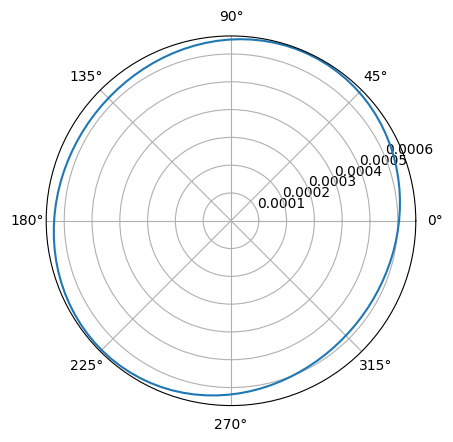

In [15]:
import matplotlib.pyplot as plt 
plt.polar(ang, E)

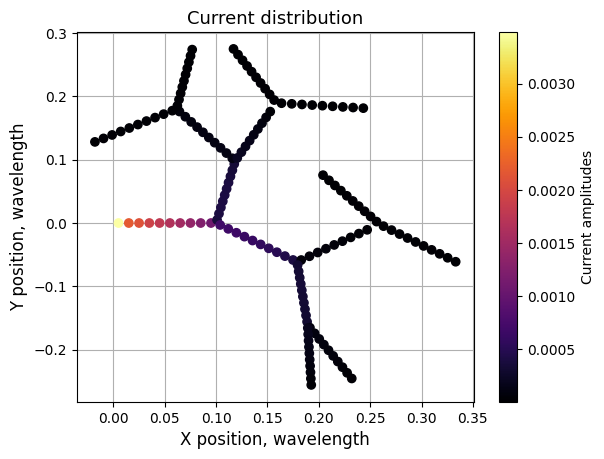

In [17]:
import geometry as gm
gm.plot_distribution(I,R, frequency)

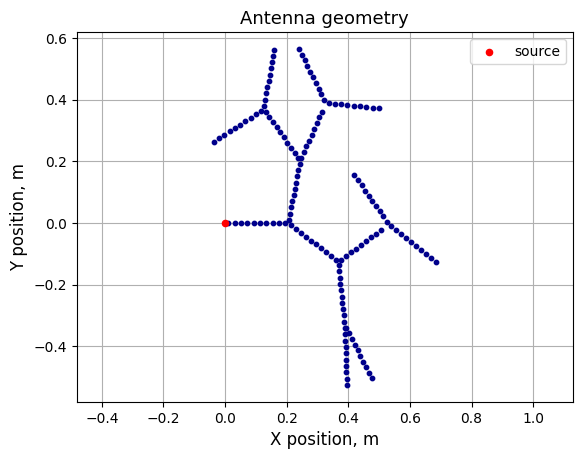

In [16]:
import geometry as gm 
segments_block, source_segments = gm.antenna_to_segments(structure_type, test_tree, basis_functions, delta_r)
gm.plot_antenna(structure_type, basis_functions, test_tree, delta_r)

In [ ]:
import numpy as np 
from scipy import linalg 
import scipy.integrate as integrate 
from tqdm import tqdm

c, mu0, eps0 = 299792458., 4*np.pi*1e-7, 8.854e-12

def basis_func(basis_functions, t_n, r_n, dr_n):
    if basis_functions == 'pulse' :
        return 1
    elif basis_functions == 'triangle':
        if -1/2 <= t_n <= 1/2 :
            return 1/2 + t_n
        elif 1/2 <= t_n <= 3/2 :
            return 3/2 - t_n

def der_basis_func(basis_functions, t_n, r_n, dr_n):
    if basis_functions == 'pulse' :
        return 0
    elif basis_functions == 'triangle':
        if -1/2 <= t_n <= 1/2 :
            return 1
        elif 1/2 <= t_n <= 3/2 :
            return -1
        
def weight_func(basis_functions, t_m, r_m, dr_m):
    if basis_functions == 'pulse' :
        return 1
    elif basis_functions == 'triangle':
        if -1/2 <= t_m <= 1/2 :
            return 1/2 + t_m
        elif 1/2 <= t_m <= 3/2 :
            return 3/2 - t_m

def Greens_func_real (t_m, t_n, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega / c
    rmn = np.linalg.norm(r_m - r_n + dr_m*(t_m-1/2) - dr_n*(t_n-1/2))
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return f_n * f_m * np.cos(-k * rmn) / rmn
def Greens_func_imag (t_m, t_n, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega / c
    rmn = np.linalg.norm(r_m - r_n + dr_m*(t_m-1/2) - dr_n*(t_n-1/2))
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return f_n * f_m * np.sin(-k * rmn) / rmn


def derderYY_Greens_func_real (t_m, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega / c
    
    if basis_functions == 'pulse' :
        t_min, t_max = 0, 1
    elif basis_functions == 'triangle' :
        t_min, t_max = -1/2, 3/2
    
    rmn_max = np.linalg.norm(r_m - r_n + dr_m*(t_m-1/2) - dr_n*(t_max-1/2))
    rmn_min = np.linalg.norm(r_m - r_n + dr_m*(t_m-1/2) - dr_n*(t_min-1/2))
    
    delta_y_max = r_m[1] - r_n[1] + dr_m[1]*(t_m-1/2) - dr_n[1]*(t_max-1/2)
    delta_y_min = r_m[1] - r_n[1] + dr_m[1]*(t_m-1/2) - dr_n[1]*(t_min-1/2)
    
    f_n_max = basis_func(basis_functions=basis_functions, t_n=t_max, r_n=r_n, dr_n=dr_n)
    f_n_min = basis_func(basis_functions=basis_functions, t_n=t_min, r_n=r_n, dr_n=dr_n)
    
    der_f_n_max = der_basis_func(basis_functions=basis_functions, t_n=t_max, r_n=r_n, dr_n=dr_n)
    der_f_n_min = der_basis_func(basis_functions=basis_functions, t_n=t_min, r_n=r_n, dr_n=dr_n)
    
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    
    return f_m * (- f_n_max * delta_y_max * (1 + 1j*k*rmn_max) * np.exp(-1j*k*rmn_max) / rmn_max**3 - der_f_n_max * np.exp(-1j*k*rmn_max) / rmn_max + f_n_min * delta_y_min * (1 + 1j*k*rmn_min) * np.exp(-1j*k*rmn_min) / rmn_min**3 + der_f_n_min * np.exp(-1j*k*rmn_min) / rmn_min).real
def derderYY_Greens_func_imag (t_m, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega / c
    
    if basis_functions == 'pulse' :
        t_min, t_max = 0, 1
    elif basis_functions == 'triangle' :
        t_min, t_max = -1/2, 3/2
    
    rmn_max = np.linalg.norm(r_m - r_n + dr_m*(t_m-1/2) - dr_n*(t_max-1/2))
    rmn_min = np.linalg.norm(r_m - r_n + dr_m*(t_m-1/2) - dr_n*(t_min-1/2))
    
    delta_y_max = r_m[1] - r_n[1] + dr_m[1]*(t_m-1/2) - dr_n[1]*(t_max-1/2)
    delta_y_min = r_m[1] - r_n[1] + dr_m[1]*(t_m-1/2) - dr_n[1]*(t_min-1/2)
    
    f_n_max = basis_func(basis_functions=basis_functions, t_n=t_max, r_n=r_n, dr_n=dr_n)
    f_n_min = basis_func(basis_functions=basis_functions, t_n=t_min, r_n=r_n, dr_n=dr_n)
    
    der_f_n_max = der_basis_func(basis_functions=basis_functions, t_n=t_max, r_n=r_n, dr_n=dr_n)
    der_f_n_min = der_basis_func(basis_functions=basis_functions, t_n=t_min, r_n=r_n, dr_n=dr_n)
    
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    
    return f_m * (- f_n_max * delta_y_max * (1 + 1j*k*rmn_max) * np.exp(-1j*k*rmn_max) / rmn_max**3 - der_f_n_max * np.exp(-1j*k*rmn_max) / rmn_max + f_n_min * delta_y_min * (1 + 1j*k*rmn_min) * np.exp(-1j*k*rmn_min) / rmn_min**3 + der_f_n_min * np.exp(-1j*k*rmn_min) / rmn_min).imag

def Zmn (structure_type, basis_functions, m, n, i, j, segments_block, omega, delta_r):
    
    k = omega / c
    
    if basis_functions == 'pulse' :
        t_min, t_max = 0, 1
    elif basis_functions == 'triangle' :
        t_min, t_max = -1/2, 3/2
        
    a_m = segments_block[m][i].radius
    tau_m = segments_block[m][i].tau
    tau_n = segments_block[n][j].tau

    r_m = segments_block[m][i].position 
    r_n = segments_block[n][j].position 
    r_m = r_m + a_m * np.array([0,0,1])
    r_m = r_m - r_n
    r_n = np.array([0,0,0])
    
    alpha = np.arctan2(tau_n[0], tau_n[1])
    matrix = np.array([[np.cos(alpha), -np.sin(alpha), 0], [np.sin(alpha), np.cos(alpha), 0], [0,0,1]])
    tau = np.dot(matrix, tau_m)
    
    dr_m = delta_r * tau
    dr_n = delta_r * np.array([0,1,0])
    Z_0 = 1j * omega * mu0 * delta_r ** 2 * (integrate.dblquad(Greens_func_real, t_max, t_min, lambda t1: t_max, lambda t2: t_min, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.dblquad(Greens_func_imag, t_max, t_min, lambda t1: t_max, lambda t2: t_min, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])
    Z = 1j * omega * mu0 / k**2  * delta_r * (integrate.quad(derderYY_Greens_func_real, t_min, t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.quad(derderYY_Greens_func_imag, t_min, t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])
    return Z_0 + Z

In [56]:
omega = 2 * np.pi * frequency
element_num = []
for i in range (len(segments_block)):
    element_num.append(len(segments_block[i]))
element_num = np.array(element_num)
impedance_block = []
for m in range(len(segments_block)):
    impedance_row = []
    for n in range(len(segments_block)):
        impedance_mn = np.zeros((len(segments_block[m]), len(segments_block[n])), dtype=complex)
        if m <= n :
            for i in range (len(segments_block[m]) + len(segments_block[n])):
                impedance_mn[max(0, len(segments_block[m])-i-1), max(0, i-len(segments_block[m]))] = Zmn(structure_type=structure_type,basis_functions=basis_functions, m=m, n=n, i=max(0, len(segments_block[m])-i-1), j=max(0, i-len(segments_block[m])), segments_block=segments_block, omega=2*np.pi*frequency, delta_r=delta_r)
                for k in range (min( min(len(segments_block[m]), len(segments_block[n])), i+1, len(segments_block[m]) + len(segments_block[n]) - i)):
                    impedance_mn[max(0, len(segments_block[m])-i-1) + k, max(0, i-len(segments_block[m])) + k] = impedance_mn[max(0, len(segments_block[m])-i-1), max(0, i-len(segments_block[m]))]
        else :
            impedance_mn = impedance_block[n][m].T
        impedance_row.append(impedance_mn)   
    impedance_block.append(impedance_row)
num_elements = sum(element_num)
impedance = np.zeros((num_elements, num_elements), dtype = complex)
cum_n = np.append(0, np.cumsum(element_num))
for i in range (len(cum_n)-1):
    for j in range (len(cum_n)-1):
        impedance[cum_n[i]:cum_n[i+1], cum_n[j]:cum_n[j+1]] = impedance_block[i][j]


[1.25732834e-18 2.05337300e-02 3.17500000e-03] [0 0 0] [0.00000000e+00 2.05337300e-02 1.25732834e-18] [0.         0.02053373 0.        ] [0.000000e+00 1.000000e+00 6.123234e-17] [6.123234e-17 1.000000e+00 6.123234e-17]
[0.       0.       0.003175] [0 0 0] [0.00000000e+00 2.05337300e-02 1.25732834e-18] [0.         0.02053373 0.        ] [0.000000e+00 1.000000e+00 6.123234e-17] [6.123234e-17 1.000000e+00 6.123234e-17]
[0.       0.       0.003175] [0 0 0] [0.00000000e+00 2.05337300e-02 1.25732834e-18] [0.         0.02053373 0.        ] [0.000000e+00 1.000000e+00 6.123234e-17] [6.123234e-17 1.000000e+00 6.123234e-17]
[-1.25732834e-18 -2.05337300e-02  3.17500000e-03] [0 0 0] [0.00000000e+00 2.05337300e-02 1.25732834e-18] [0.         0.02053373 0.        ] [0.000000e+00 1.000000e+00 6.123234e-17] [6.123234e-17 1.000000e+00 6.123234e-17]
[ 0.00725977 -0.39314797  0.003175  ] [0 0 0] [-1.45195397e-02  1.45195397e-02  1.25732834e-18] [0.         0.02053373 0.        ] [-7.07106781e-01  7.071067

In [54]:
print(np.abs(impedance))

[[280.98577103 505.84562423  13.40008448  12.94368179]
 [505.84562423 280.98577103  14.10332139  13.40008448]
 [ 13.40008448  14.10332139 373.14435202 238.18577424]
 [ 12.94368179  13.40008448 238.18577424 373.14435202]]


In [50]:
import matrix_elements as matrix
impedance_past = matrix.calculate_impedance(basis_functions, structure_type, segments_block, frequency, delta_r)

In [51]:
print(np.abs(impedance_past))

[[2.07280017e+03 6.97712891e+02 1.30431426e-01 1.25197030e-01]
 [6.97712891e+02 2.07280017e+03 1.47175098e-01 1.30431426e-01]
 [1.30431426e-01 1.47175098e-01 2.07280017e+03 6.97712891e+02]
 [1.25197030e-01 1.30431426e-01 6.97712891e+02 2.07280017e+03]]
